In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from keras.callbacks import EarlyStopping
from datetime import datetime
import tensorflow as tf
from tensorflow import keras

In [ ]:
def plot_series(datelist ,series, format="-", start=0, end=None):
    plt.plot(datelist, series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [ ]:
dataset= pd.read_csv('gdrive/My Drive/HEROMOTOCO.csv')

In [ ]:
dataset

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HEROHONDA,EQ,1145.20,1200.00,1236.80,1171.00,1209.95,1207.60,1209.11,10631,1.285401e+12,NaN,NaN,NaN
1,2000-01-04,HEROHONDA,EQ,1207.60,1200.00,1220.00,1176.00,1200.00,1199.85,1200.93,19849,2.383719e+12,NaN,NaN,NaN
2,2000-01-05,HEROHONDA,EQ,1199.85,1155.00,1178.00,1140.00,1140.00,1143.80,1159.74,2525,2.928355e+11,NaN,NaN,NaN
3,2000-01-06,HEROHONDA,EQ,1143.80,1183.00,1189.95,1150.25,1165.00,1161.40,1167.29,4375,5.106887e+11,NaN,NaN,NaN
4,2000-01-07,HEROHONDA,EQ,1161.40,1140.00,1140.00,1069.00,1105.00,1106.55,1103.52,9093,1.003429e+12,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5136,2020-08-25,HEROMOTOCO,EQ,3015.05,3044.00,3052.95,2957.85,2985.95,2969.75,3002.25,1324090,3.975243e+14,71119.0,397548.0,0.3002
5137,2020-08-26,HEROMOTOCO,EQ,2969.75,3110.00,3181.35,3070.00,3160.45,3160.75,3119.68,4651111,1.450998e+15,207879.0,792853.0,0.1705
5138,2020-08-27,HEROMOTOCO,EQ,3160.75,3159.00,3170.00,3107.50,3136.00,3141.75,3130.03,1431518,4.480691e+14,76057.0,230374.0,0.1609
5139,2020-08-28,HEROMOTOCO,EQ,3141.75,3119.05,3164.00,3050.65,3068.15,3059.30,3101.21,1838010,5.700058e+14,105935.0,525422.0,0.2859


In [ ]:
datelist = list(dataset['Date'])
datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]


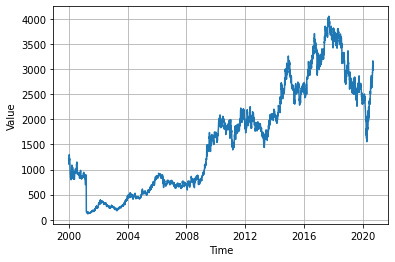

In [ ]:
plot_series(datelist,dataset['Close'])

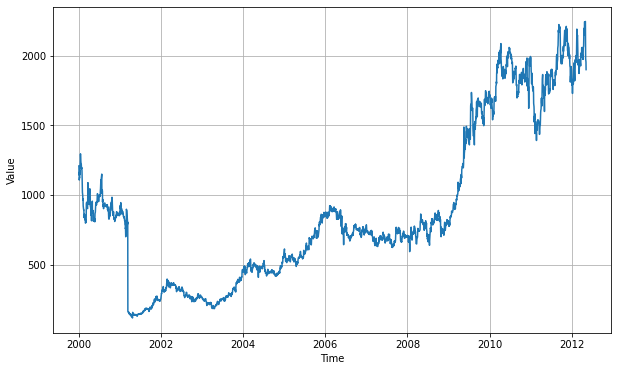

In [ ]:
Train=dataset['Close']
time = np.array(range(len(Train)))
split_time = int(0.6*len(Train))
time_train = datelist[:split_time]
x_train = Train[:split_time]
time_valid = datelist[split_time:]
x_valid = Train[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

In [ ]:
def accuracy(x_valid,prediction,retmetric=False):
 MAE=keras.metrics.mean_absolute_error(x_valid,prediction).numpy()
 MSE=keras.metrics.mean_squared_error(x_valid, prediction).numpy()
 print("MSE : ",keras.metrics.mean_squared_error(x_valid, prediction).numpy())
 print("MAE: " ,keras.metrics.mean_absolute_error(x_valid,prediction).numpy())
 if retmetric == True:
  return MAE
 

In [ ]:
naive_forecast =Train[split_time - 1:-1]

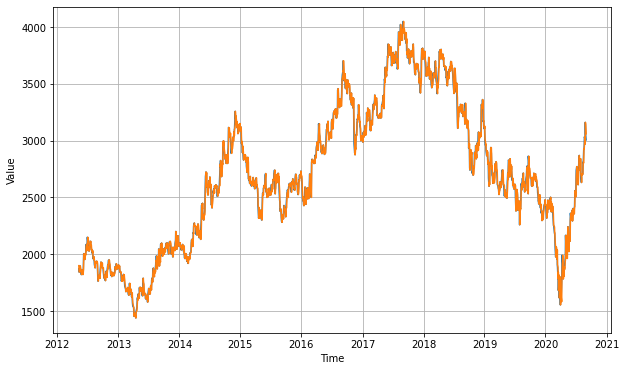

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=2057)
plot_series(time_valid, naive_forecast)

In [ ]:
accuracy(x_valid,naive_forecast)

MSE :  2067.1765751093817
MAE:  33.006076810889645


In [ ]:
def moving_average_forecast(series, window_size):
  forecast = []
  for time in range(len(series) - window_size):
    sum=np.sum(series[time: (time + window_size)])
    mva=sum/window_size
    forecast.append(mva)
  return np.array(forecast)

MSE :  23739.321950180787
MAE:  120.25119591638308


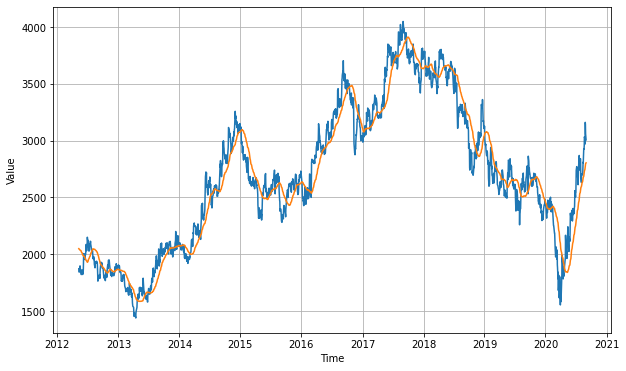

In [ ]:
moving_avg = moving_average_forecast(Train, 40)[split_time - 40:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)
accuracy(x_valid,moving_avg)

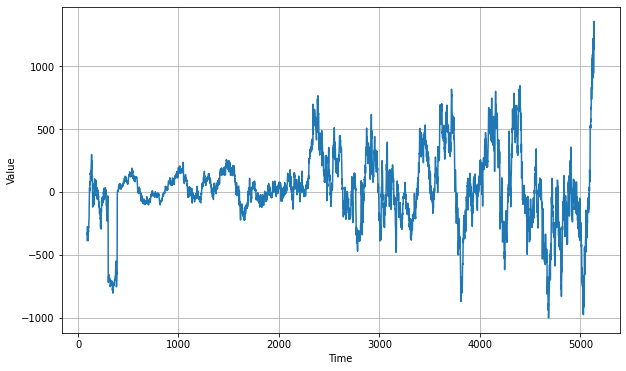

In [ ]:
diff_series = (np.array(Train[90:]) - np.array(Train[:-90]))
diff_time = time[90:]
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()


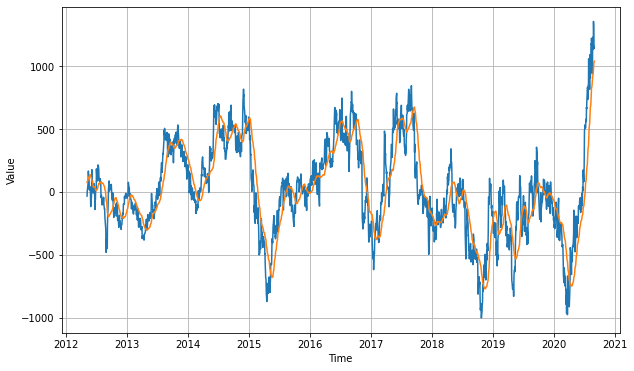

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 30)[split_time - 90 - 30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 90:])
plot_series(time_valid, diff_moving_avg)
plt.show()

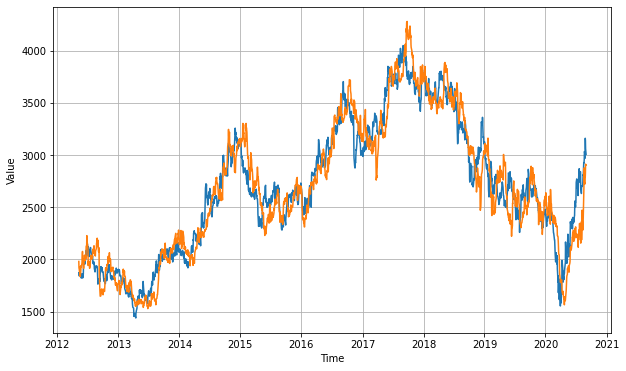

In [ ]:
diff_moving_avg_plus_past = Train[split_time - 90:-90] + diff_moving_avg
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
accuracy(x_valid,diff_moving_avg_plus_past)

MSE :  36026.6344634284
MAE:  149.2961853832442


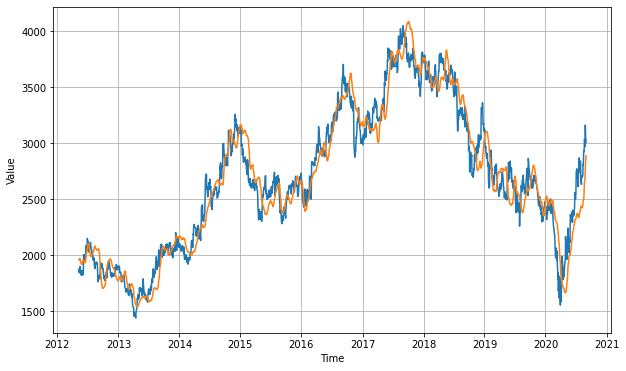

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(Train[split_time - 100:-90], 10) + diff_moving_avg
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
accuracy(x_valid,diff_moving_avg_plus_smooth_past)

MSE :  25652.834646579435
MAE:  126.03045616593744


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 90
batch_size = 128
shuffle_buffer_size = len(x_train)

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(500, activation="relu"), 
    tf.keras.layers.Dense(1)
])


#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    #lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, verbose=2)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/100
24/24 - 0s - loss: 1055201.8750
Epoch 2/100
24/24 - 0s - loss: 11286.1064
Epoch 3/100
24/24 - 0s - loss: 9320.7783
Epoch 4/100
24/24 - 0s - loss: 8033.8999
Epoch 5/100
24/24 - 0s - loss: 7216.8599
Epoch 6/100
24/24 - 0s - loss: 6690.9014
Epoch 7/100
24/24 - 0s - loss: 6095.1973
Epoch 8/100
24/24 - 0s - loss: 5763.5186
Epoch 9/100
24/24 - 0s - loss: 5404.7046
Epoch 10/100
24/24 - 0s - loss: 5078.2490
Epoch 11/100
24/24 - 0s - loss: 4814.5776
Epoch 12/100
24/24 - 0s - loss: 4700.3960
Epoch 13/100
24/24 - 0s - loss: 4428.3564
Epoch 14/100
24/24 - 0s - loss: 4339.1177
Epoch 15/100
24/24 - 0s - loss: 4224.0024
Epoch 16/100
24/24 - 0s - loss: 4049.5696
Epoch 17/100
24/24 - 0s - loss: 4072.5325
Epoch 18/100
24/24 - 0s - loss: 3949.0601
Epoch 19/100
24/24 - 0s - loss: 3853.1951
Epoch 20/100
24/24 - 0s - loss: 3752.5674
Epoch 21/100
24/24 - 0s - loss: 3619.3474
Epoch 22/100
24/24 - 0s - loss: 3605.934

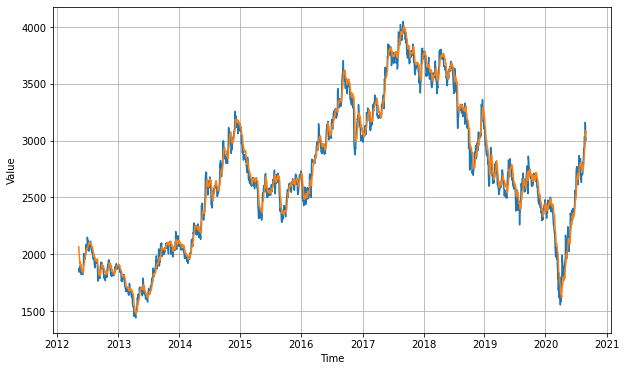

In [ ]:
forecast = []
for time in range(len(Train) - window_size):
  forecast.append(model.predict(np.array(Train[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
accuracy(x_valid,results)

In [ ]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 2500.0)
])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
 #   lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=5e-5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=26)
history = model.fit(dataset, epochs=500,verbose=2,callbacks=[es])

Epoch 1/500
24/24 - 9s - loss: 1576.9714 - mae: 1577.4714
Epoch 2/500
24/24 - 9s - loss: 475.8063 - mae: 476.3059
Epoch 3/500
24/24 - 9s - loss: 332.0905 - mae: 332.5900
Epoch 4/500
24/24 - 10s - loss: 237.7803 - mae: 238.2789
Epoch 5/500
24/24 - 9s - loss: 163.1562 - mae: 163.6552
Epoch 6/500
24/24 - 9s - loss: 82.3967 - mae: 82.8957
Epoch 7/500
24/24 - 9s - loss: 62.7573 - mae: 63.2542
Epoch 8/500
24/24 - 9s - loss: 54.3403 - mae: 54.8377
Epoch 9/500
24/24 - 9s - loss: 48.5287 - mae: 49.0256
Epoch 10/500
24/24 - 9s - loss: 46.9499 - mae: 47.4469
Epoch 11/500
24/24 - 9s - loss: 44.6895 - mae: 45.1859
Epoch 12/500
24/24 - 9s - loss: 40.4915 - mae: 40.9870
Epoch 13/500
24/24 - 9s - loss: 40.2053 - mae: 40.7015
Epoch 14/500
24/24 - 9s - loss: 39.9229 - mae: 40.4183
Epoch 15/500
24/24 - 9s - loss: 44.6599 - mae: 45.1573
Epoch 16/500
24/24 - 9s - loss: 41.4887 - mae: 41.9854
Epoch 17/500
24/24 - 9s - loss: 37.4979 - mae: 37.9931
Epoch 18/500
24/24 - 9s - loss: 36.0258 - mae: 36.5206
Epoch 

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 600])

KeyError: ignored

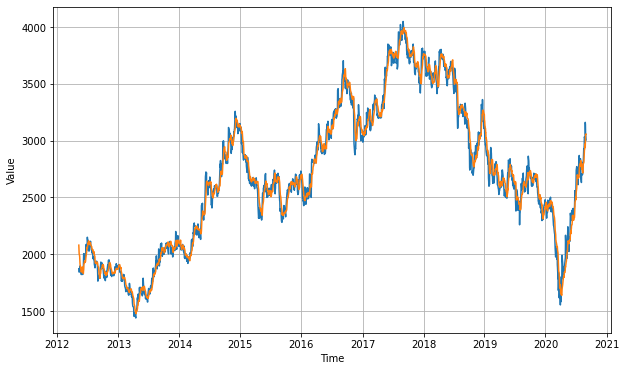

In [ ]:
forecast = []
for time in range(len(Train) - window_size):
  forecast.append(model.predict(np.array(Train[time:time + window_size])[np.newaxis]))
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
accuracy(x_valid,results)

MSE :  5813.655
MAE:  58.12811
